#  Motion Planning Transformers: One Model to Plan them All

In [1]:
import matplotlib.pyplot as plt

In [2]:
%matplotlib notebook

In [3]:
import os
from os import path as osp
import numpy as np
import pickle

from utils.utils import geom2pix, ValidityChecker

from skimage import io

In [4]:
import torch
import torch.nn.functional as F
import json

from transformer import Models
from dataLoader import get_encoder_input
try:
    from ompl import base as ob
    from ompl import geometric as og
    from ompl import util as ou
except ImportError:
    raise ImportError("Container does not have OMPL installed")
import time    

In [5]:
def getHashTable(mapSize):
    '''
    Return the hashTable for the given map
    NOTE: This hastable only works for the  patch_embedding network defined in the
    transformers/Models.py file.
    :param mapSize: The size of the map
    :returns list: the hashTable to convert 1D token index to 2D image positions
    '''
    H, W = mapSize
    Hhat = np.floor((H-8)/4) - 1
    What = np.floor((W-8)/4) - 1
    tokenH = int((Hhat+6)//5)
    tokenW = int((What+6)//5)
    return [(20*r+4, 20*c+4) for c in range(tokenH) for r in range(tokenW)]

In [6]:
receptive_field =32
res = 0.05
def get_path(start, goal, input_map, patch_map, plannerType, cost, exp=False):
    '''
    Plan a path given the start, goal and patch_map.
    :param start:
    :param goal:
    :param patch_map:
    :param plannerType: The planner type to use
    :param cost: The cost of the path
    :param exp: If exploration is enabled
    returns bool: Returns True if a path was planned successfully.
    '''
    mapSize = input_map.shape
    # Planning parametersf
    space = ob.RealVectorStateSpace(2)
    bounds = ob.RealVectorBounds(2)
    bounds.setLow(0.0)
    bounds.setHigh(0, mapSize[1]*res) # Set width bounds (x)
    bounds.setHigh(1, mapSize[0]*res) # Set height bounds (y)
    space.setBounds(bounds)
    si = ob.SpaceInformation(space)
    ValidityCheckerObj = ValidityChecker(si, input_map, patch_map)
    si.setStateValidityChecker(ValidityCheckerObj)

    StartState = ob.State(space)
    StartState[0] = start[0]
    StartState[1] = start[1]

    GoalState = ob.State(space)
    GoalState[0] = goal[0]
    GoalState[1] = goal[1]

    success = False

    # Define planning problem
    pdef = ob.ProblemDefinition(si)
    pdef.setStartAndGoalStates(StartState, GoalState, 0.1)

    # Set up the objective function
    obj = getPathLengthObjective(cost, si)
    pdef.setOptimizationObjective(obj)
    
    if plannerType=='rrtstar':
        planner = og.RRTstar(si)
    elif plannerType=='informedrrtstar':
        planner = og.InformedRRTstar(si)
    else:
        raise TypeError(f"Planner Type {plannerType} not found")
    
    # Set the problem instance the planner has to solve

    planner.setProblemDefinition(pdef)
    planner.setup()

    # Attempt to solve the planning problem in the given time
    if exp:        
        startTime = time.time()
        solved = planner.solve(1.0)
        if not pdef.hasExactSolution():
            NewValidityCheckerObj = ValidityChecker(si, input_map)
            si.setStateValidityChecker(NewValidityCheckerObj)
            solved = planner.solve(89.0)
        planTime = time.time()-startTime
    else:
        startTime = time.time()
        solved = planner.solve(90)
        planTime = time.time() - startTime
    plannerData = ob.PlannerData(si)
    planner.getPlannerData(plannerData)
    numVertices = plannerData.numVertices()

    if pdef.hasExactSolution():
        success = True

        print("Found Solution")
        path = [
            [pdef.getSolutionPath().getState(i)[0], pdef.getSolutionPath().getState(i)[1]]
            for i in range(pdef.getSolutionPath().getStateCount())
            ]
    else:
        path = [[start[0], start[1]], [goal[0], goal[1]]]

    return path, planTime, numVertices, success



def get_patch(model, start_pos, goal_pos, input_map):
    '''
    Return the patch map for the given start and goal position, and the network
    architecture.
    :param model:
    :param start: 
    :param goal:
    :param input_map:
    '''
    # Identitfy Anchor points
    encoder_input = get_encoder_input(input_map, goal_pos, start_pos)
    hashTable = getHashTable(input_map.shape)
    predVal = model(encoder_input[None,:].float().cuda())
    predClass = predVal[0, :, :].max(1)[1]

    predProb = F.softmax(predVal[0, :, :], dim=1)
    possAnchor = [hashTable[i] for i, label in enumerate(predClass) if label==1]

    # Generate Patch Maps
    patch_map = np.zeros_like(input_map)
    map_size = input_map.shape
    for pos in possAnchor:
        goal_start_x = max(0, pos[0]- receptive_field//2)
        goal_start_y = max(0, pos[1]- receptive_field//2)
        goal_end_x = min(map_size[1], pos[0]+ receptive_field//2)
        goal_end_y = min(map_size[0], pos[1]+ receptive_field//2)
        patch_map[goal_start_y:goal_end_y, goal_start_x:goal_end_x] = 1.0
    return patch_map, predProb

def getPathLengthObjective(cost, si):
    '''
    Return the threshold objective for early termination
    :param cost: The cost of the original RRT* path
    :param si: An object of class ob.SpaceInformation
    :returns : An object of class ob.PathLengthOptimizationObjective
    '''
    obj = ob.PathLengthOptimizationObjective(si)
    obj.setCostThreshold(ob.Cost(cost))
    return obj

### Load Trained Model

Pick either the Point or Dubins Car model to load.

In [137]:
# Define the network
device='cuda' if torch.cuda.is_available() else 'cpu'

modelFolder = 'pretrained_models/'
epoch = 434

modelFile = osp.join(modelFolder, f'model_params.json')
model_param = json.load(open(modelFile))

transformer = Models.Transformer(**model_param)
_ = transformer.to(device)

In [138]:
checkpoint = torch.load(osp.join(modelFolder, f'model_epoch_{epoch}.pkl'))
transformer.load_state_dict(checkpoint['state_dict'])

_ = transformer.eval()

###  Load the Map

Choose an environment to plan paths for. For the  point robot, you can choose between forest or maze.

<IPython.core.display.Javascript object>


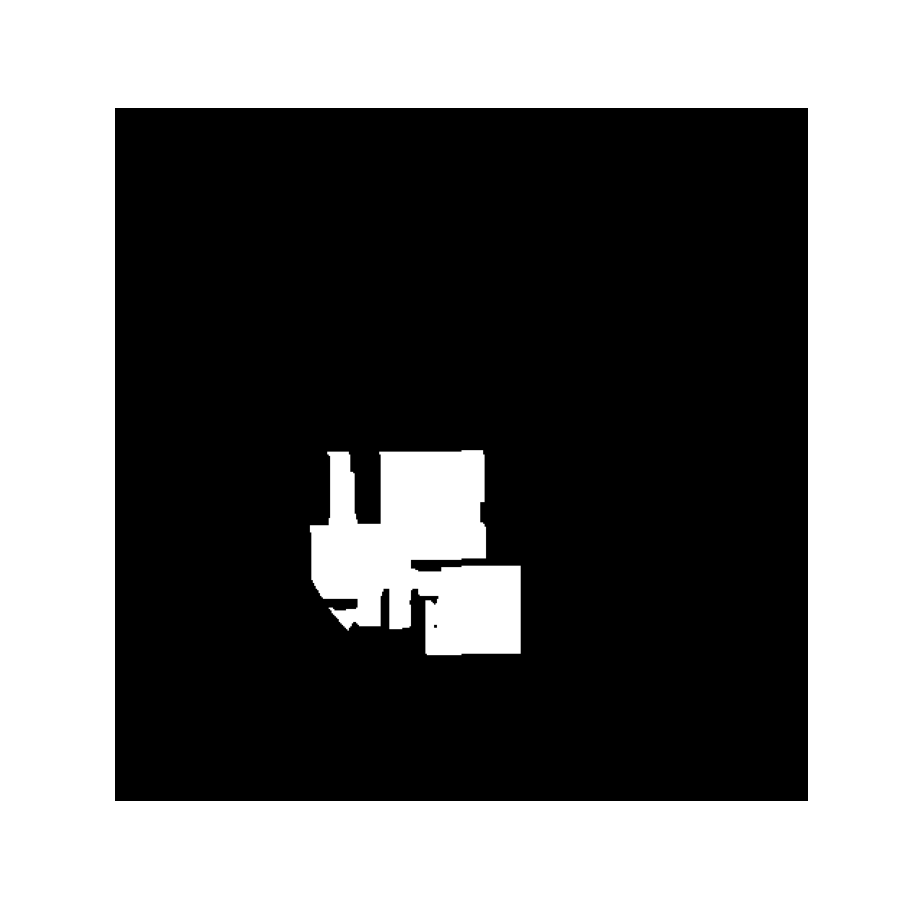

(-0.5, 479.5, 479.5, -0.5)

In [202]:
# Plot the patches
env_num =15
envFolder = f'data/maps/val/env{env_num:06d}'
MazeMap = io.imread(osp.join(envFolder, f'map_{env_num}.png'), as_gray=True)

fig, ax = plt.subplots(figsize=(9, 9))
ax.imshow(MazeMap, cmap='gray')
ax.axis('off')

## Define the Start and Goal Point

Define your own start and goal point or choose a path from the validation data

<IPython.core.display.Javascript object>


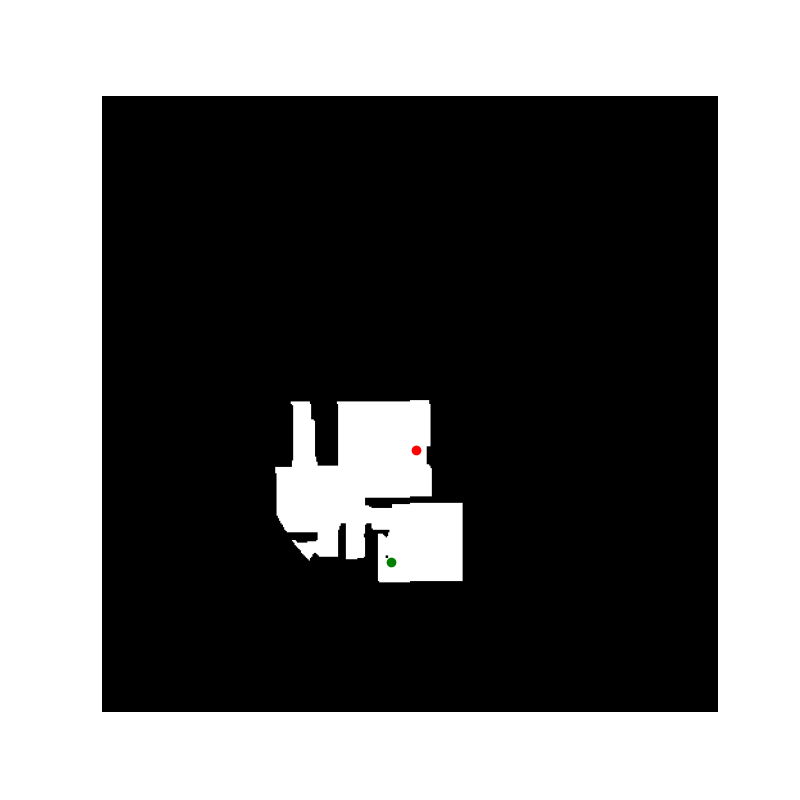

(-0.5, 479.5, 479.5, -0.5)

In [203]:
# Plot the path
pathNum = 5
data = pickle.load(open(osp.join(envFolder, f'path_{pathNum}.p'), 'rb'))
path = data['path_interpolated']
goal_pos = geom2pix(path[0, :])
start_pos = geom2pix(path[-1, :])

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(MazeMap, cmap='gray')
ax.scatter(goal_pos[0], goal_pos[1], color='r', zorder=3)
ax.scatter(start_pos[0], start_pos[1], color='g', zorder=3)
ax.axis('off')

### Generate the Patch

In [204]:
patch_map, predProb = get_patch(transformer, start_pos, goal_pos, MazeMap)

<IPython.core.display.Javascript object>


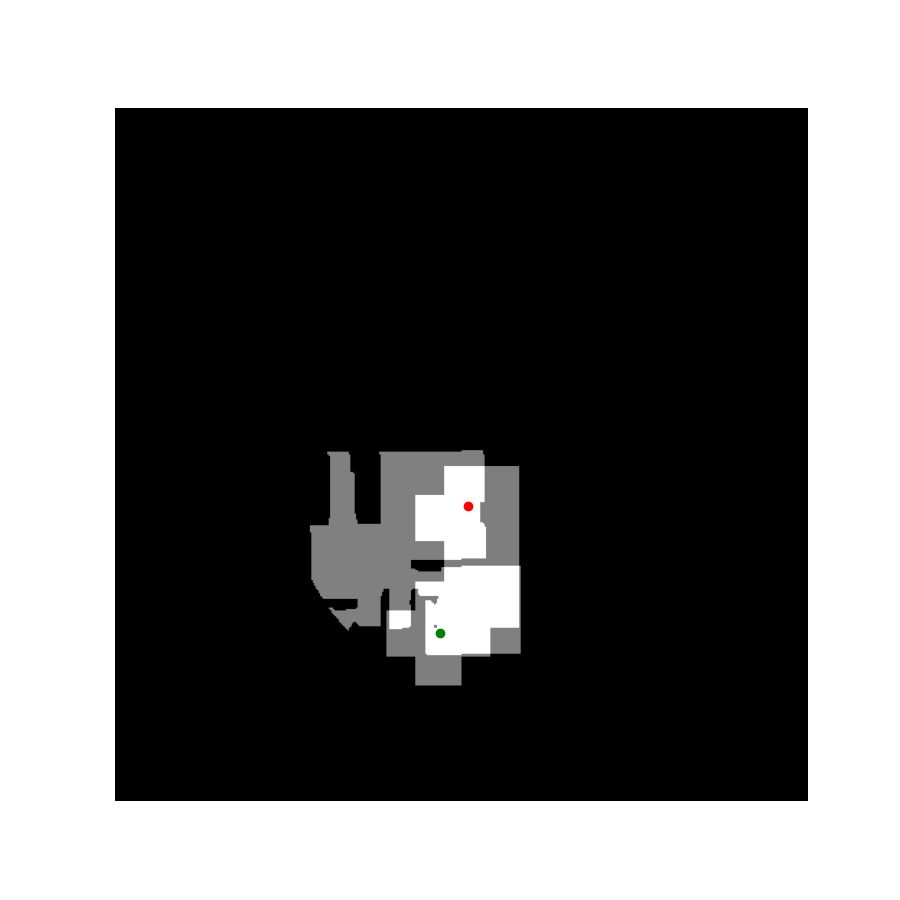

(-0.5, 479.5, 479.5, -0.5)

In [205]:
fig, ax = plt.subplots(figsize=(9, 9))

ax.imshow(MazeMap, cmap='gray')
ax.imshow(patch_map, cmap='gray', alpha=0.5)
ax.scatter(goal_pos[0], goal_pos[1], color='r', zorder=3)
ax.scatter(start_pos[0], start_pos[1], color='g', zorder=3)
ax.axis('off')

### Plan RRT* or IRRT* Path

Choose either RRT* or IRRT* to plan the path on the given patches.

In [198]:
cost = np.linalg.norm(np.diff(path, axis=0), axis=1).sum()

method = 'rrtstar' # or 'informedrrtstar'
MPTpath, t, v, success = get_path(path[0,:], path[-1, :], MazeMap, patch_map, method, cost)

MPTpixelPos = np.array([geom2pix(pos) for pos in MPTpath])

In [206]:
pathPix = [geom2pix(pos) for pos in path]

uniqueId = []
for pos in pathPix:
    if pos not in uniqueId:
        uniqueId.append(pos)
pathPixelPos = np.array([geom2pix(pos) for pos in data['path']])# Generate Patch Maps
truePatchMap = np.zeros_like(MazeMap)
map_size = MazeMap.shape
receptive_field = 32
for pos in uniqueId:
    goal_start_x = max(0, pos[0]- receptive_field//2)
    goal_start_y = max(0, pos[1]- receptive_field//2)
    goal_end_x = min(map_size[0], pos[0]+ receptive_field//2)
    goal_end_y = min(map_size[1], pos[1]+ receptive_field//2)
    truePatchMap[goal_start_y:goal_end_y, goal_start_x:goal_end_x] = 1.0

<IPython.core.display.Javascript object>


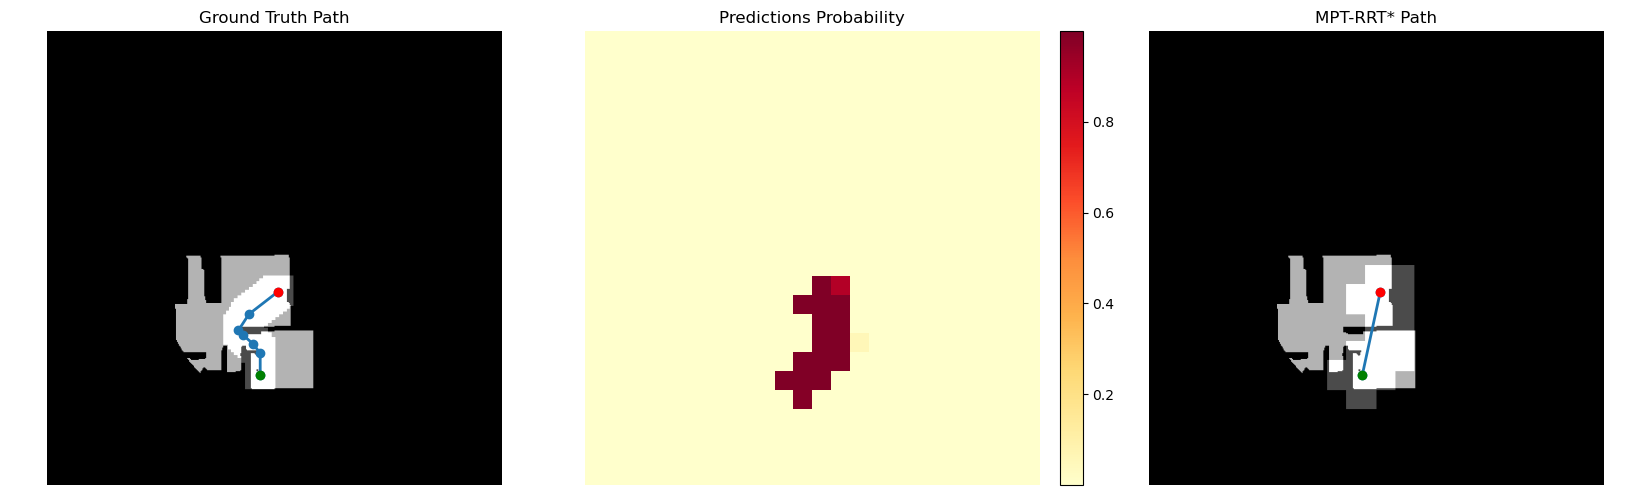

In [207]:
fig, ax = plt.subplots(1, 3, figsize=(16.5,5), dpi=100)

ax[0].set_title('Ground Truth Path')
ax[0].imshow(MazeMap, cmap='gray')
ax[0].imshow(truePatchMap, cmap='gray', alpha=0.3)
ax[0].plot(pathPixelPos[:,0], pathPixelPos[:,1], marker='o', linewidth=2)
ax[0].scatter(goal_pos[0], goal_pos[1], color='r', zorder=3)
ax[0].scatter(start_pos[0], start_pos[1], color='g', zorder=3)
ax[0].axis('off')

predMap = predProb[:, 1].cpu().detach().numpy()
im = ax[1].imshow(predMap.reshape((24, 24)), cmap="YlOrRd")
ax[1].set_title('Predictions Probability')
ax[1].axis('off')
cbar = fig.colorbar(im, ax=ax[1], fraction=0.046, pad=0.04)

ax[2].set_title('MPT-RRT* Path')
ax[2].imshow(MazeMap, cmap='gray')
ax[2].imshow(patch_map, cmap='gray', alpha=0.3)
ax[2].plot(MPTpixelPos[:,0], MPTpixelPos[:,1], marker='o', linewidth=2)
ax[2].scatter(goal_pos[0], goal_pos[1], color='r', zorder=3)
ax[2].scatter(start_pos[0], start_pos[1], color='g', zorder=3)
ax[2].axis('off')
plt.tight_layout(w_pad=0.1)